# Scientific Computing Group: Tomography pipeline for Cateretê
 
- #### Questions? E-mail gcc@lnls.br
- #### Documentation about the ssc-cdi package: https://gcc.lnls.br/wiki/
- #### Requires sscCdi 0.9.1 and sscRaft 2.2.10

## Imports

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import json, h5py

import sscCdi
print(f'sscCdi version: {sscCdi.__version__}')

plt.rcParams['image.cmap'] = 'cividis' # select standard colormap for plots here

import sscRaft
print(f'sscRaft version: {sscRaft.__version__}')

sscCdi version: 0.9.1
sscRaft version: 2.2.10


## Load data

In [4]:
dic = {}
dic["recon_method"]  = "ptycho" # ptycho or pwcdi
dic["contrast_type"] = "complex" # phase, magnitude or complex
dic["sinogram_path"] = "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/phantom_donut.hdf5"

dic = sscCdi.beamlines.caterete.cat_tomo_processing.define_CAT_tomo_paths(dic) # defines all paths to temporary sinograms
dic


#TO OPEN AN HDF5 FILE, USE:
# path = '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_ordered_angles_projected.h5'
# data = h5py.File(path,'r')['entry/data'][()]

{'recon_method': 'ptycho',
 'contrast_type': 'complex',
 'sinogram_path': '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/phantom_donut.hdf5',
 'output_folder': '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut',
 'filename': 'phantom_donut_complex',
 'temp_folder': '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp',
 'ordered_angles_filepath': '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_ordered_angles.h5',
 'projected_angles_filepath': '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_ordered_angles_projected.h5',
 'ordered_object_filepath': '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_ordered_object.h5',
 'cropped_sinogram_filepath': '/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/0000

In [5]:
obj, angles = sscCdi.beamlines.caterete.cat_tomo_processing.read_data(dic)
print(f"Object shape = {obj.shape} \t Number of angles: {angles.shape}")

Object shape = (361, 256, 256) 	 Number of angles: (361, 2)


(<matplotlib.image.AxesImage at 0x7fde85cd64f0>, Text(0.5, 1.0, 'Phase'))

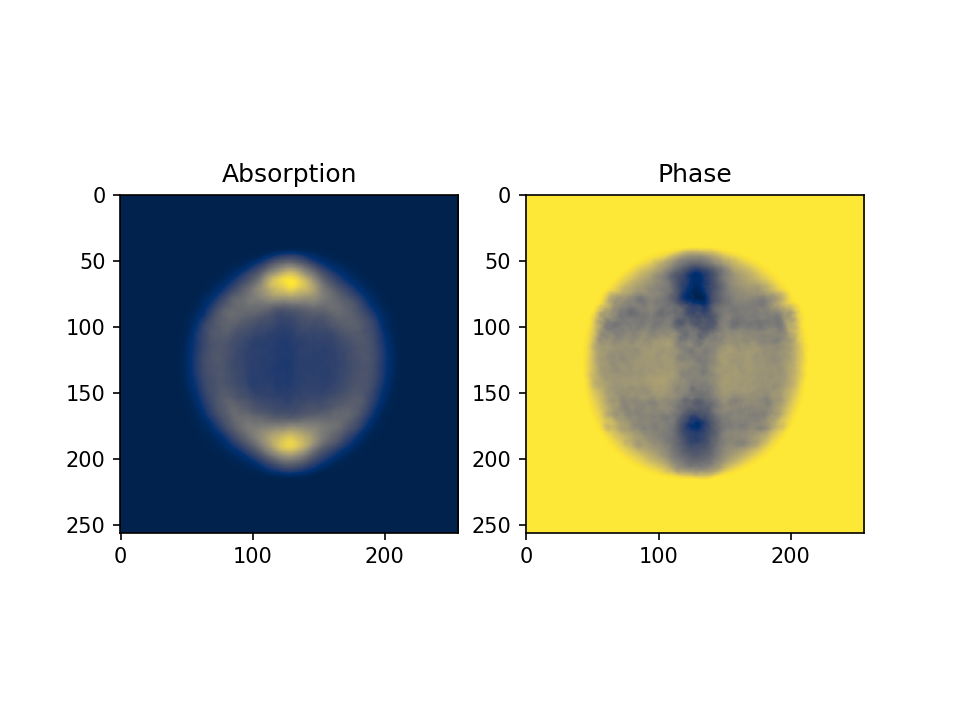

In [6]:
projection = np.sum(obj,axis=0)

fig, ax = plt.subplots(1,2,dpi=150) # Preview projection of frames
ax[0].imshow(np.abs(projection)), ax[0].set_title('Absorption')
ax[1].imshow(np.angle(projection)), ax[1].set_title('Phase')

In [7]:
# sscCdi.deploy_visualizer(obj,type='phase',title='Original sinogram',cmap='gray') # type = amplitude, phase, real or imag

## Crop data

In [8]:
dic["top_crop"]    = 2 # n of pixels to remove on top
dic["bottom_crop"] = 2 # n of pixels to remove on bottom
dic["left_crop"]   = 2 # n of pixels to remove on left
dic["right_crop"]  = 2 # n of pixels to remove on right

cropped_data = sscCdi.processing.crop_volume(obj,dic["top_crop"],dic["bottom_crop"],dic["left_crop"] ,dic["right_crop"] ,cropped_savepath=dic['cropped_sinogram_filepath'] )

Cropped sinogram shape: (361, 252, 252)
Saving cropped volume...
Saved cropped volume at:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_cropped_sinogram.h5
Time elapsed: 0.00 s


In [9]:
sscCdi.deploy_visualizer(cropped_data,type='phase',title="Cropped sinogram",cmap='gray')

In [10]:
dic["bad_frames_before_sorting"] = []
cropped_data, angles = sscCdi.remove_frames_from_sinogram(cropped_data,angles,dic["bad_frames_before_sorting"],ordered_object_filepath=dic['cropped_sinogram_filepath'])

Original shape:  (361, 252, 252)
New shape:  (361, 252, 252)


## Sort data

In [11]:
sorted_data, sorted_angles = sscCdi.sort_sinogram_by_angle(cropped_data, angles,object_savepath=dic['ordered_object_filepath'],angles_savepath=dic['ordered_angles_filepath']) 

Saving sorted angles...
Saved sorted angles at:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_ordered_angles.h5
Saving sorted sinogram...
Saved sorted object at:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_ordered_object.h5
Time elapsed: 0.09 s


In [12]:
sscCdi.deploy_visualizer(sorted_data,type='phase',title="Ordered sinogram",cmap='gray')

## Alignment Cross Correlation (CC) 

Finding shift between neighboor slices...


Search in progress...: 100%|█████████▉| 360/361 [00:03<00:00, 95.18it/s] 


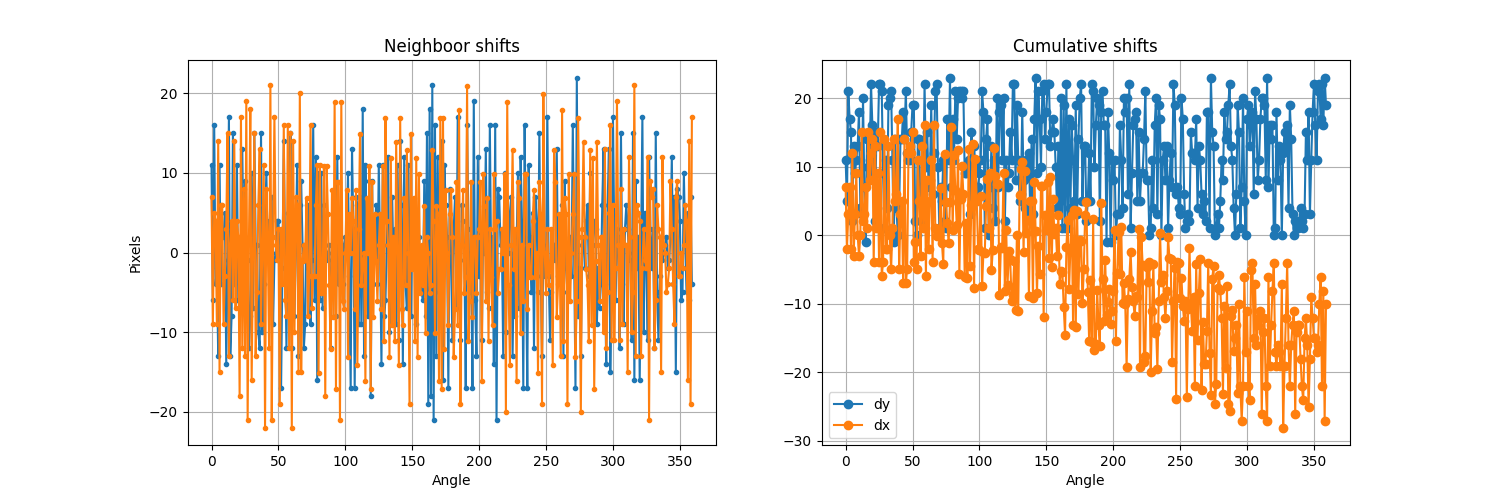

In [13]:
dic["CC_correlate_via_variance_field"] = False # if True, performs alignment of the variance (derivative) of the images. Only use True if phase wrapping is present!
dic["CC_return_common_valid_region"] = True    # if True, will return images containing only common ROI for all slices
dic["CC_remove_null_borders"] = True           # if True, removes the null borders of the image which represent the biggest shift in each direction
dic["CC_downscaling_factor"] = 1             # how many times to downsample the image before alignment. Recommended is 4.
dic["CC_fft_upsampling"] = 10                  # how much to upsample the data in reciprocal space for alignment. Recommended is 10. See: https://opg.optica.org/ol/abstract.cfm?uri=ol-33-2-156

neighbor_shifts, total_shift = sscRaft.alignment.get_shifts_of_local_variance_parallel(sorted_data,fft_upsampling=dic["CC_fft_upsampling"],downscaling_factor=dic["CC_downscaling_factor"], use_gradient=dic["CC_correlate_via_variance_field"],plot=True)

In [14]:
aligned_data_CC = sscRaft.alignment.shift_and_crop_volume(sorted_data,total_shift,return_common_valid_region=dic["CC_return_common_valid_region"], remove_null_borders = dic["CC_remove_null_borders"])
sscCdi.misc.open_or_create_h5_dataset(dic["cc_aligned_sinogram_filepath"],'entry','data',aligned_data_CC,create_group=True)
print('Aligned sinogram saved at: ',dic["cc_aligned_sinogram_filepath"]);

Using 32 CPUs


100%|█████████▉| 360/361 [00:00<00:00, 481.03it/s]


Aligned sinogram saved at:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_cc_aligned_sinogram.h5


In [15]:
sscCdi.misc.deploy_visualizer(aligned_data_CC,type='phase',title='CC',cmap='gray',axis=0) # select axis

## Alignment Vertical Mass Fluctuation (VMF)

In [16]:
dic["VMF_vertical_region"] = (0,250)       # (top, bottom). Select a region with good data (no phase wrapping is better) avoiding the borders
dic["VMF_use_phase_gradient"] = False         # if True, will align over the gradient of the phase images, making it indifferent to phase ramps
dic["VMF_filter_sigma"] = 0                  # sigma of a Gaussian filter applied to the curves prior to alignment. May help to reduce the influence of noise and fine features when overlapping curves
dic["VMF_return_common_valid_region"] = True # if True, will return images containing only common ROI for all slices
dic["VMF_remove_null_borders"] = True        # if True, removes the null borders of the image which represent the biggest shift in each direction
dic["VMF_plot"] = None                       # if True, shows VMF curves of the VMF_vertical_region before and after alignment

aligned_data_VMF, curves, total_shift = sscRaft.alignment_vertical_mass_fluctuation(aligned_data_CC, curve_portion = dic["VMF_vertical_region"],  use_phase_gradient = dic["VMF_use_phase_gradient"],  filter_sigma = dic["VMF_filter_sigma"], return_common_valid_region=dic["VMF_return_common_valid_region"], remove_null_borders = dic["VMF_remove_null_borders"], plot = dic["VMF_plot"]) # if data is not equalized, phase gradient should be used
sscCdi.misc.open_or_create_h5_dataset(dic["vmf_aligned_sinogram_filepath"],'entry','data',aligned_data_VMF,create_group=True)

print('Aligned sinogram saved at: ',dic["vmf_aligned_sinogram_filepath"])

Calculating 1D mass distribution...
Finding shift between neighboor slices...
Shifting slices...
Aligning volume...
Aligning slice #0/361
Aligning slice #50/361
Aligning slice #100/361
Aligning slice #150/361
Aligning slice #200/361
Aligning slice #250/361
Aligning slice #300/361
Aligning slice #350/361
Aligned sinogram saved at:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_vmf_aligned_sinogram.h5


In [17]:
sscCdi.misc.deploy_visualizer(aligned_data_VMF,type='phase',title='VMF',cmap='gray',axis=0)

Calculating 1D mass distribution...
Calculating 1D mass distribution...


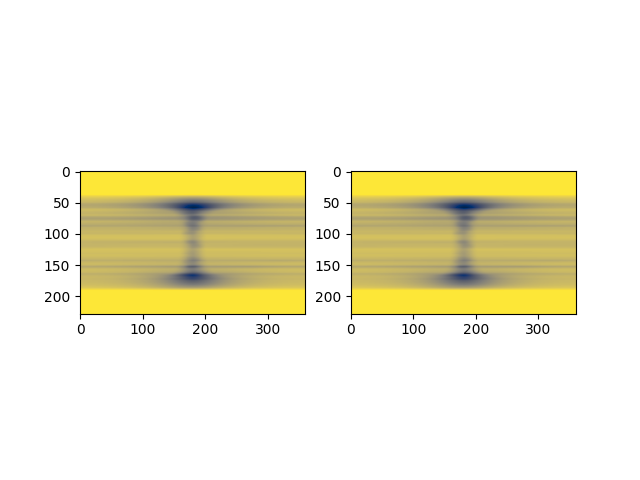

In [18]:
curves_CC = sscRaft.get_VMF_curves(aligned_data_CC,use_phase_gradient=False,filter_sigma=0,curve_portion=None)
curves_VMF = sscRaft.get_VMF_curves(aligned_data_VMF,use_phase_gradient=False,filter_sigma=0,curve_portion=None)

fig, ax = plt.subplots(1,2)
ax[1].imshow(np.angle(curves_CC).T)
ax[0].imshow(np.angle(curves_VMF).T)

## Unwrap

In [19]:
dic["bad_frames_before_unwrap"] = []
aligned_data_VMF = sscCdi.processing.make_bad_frame_null(dic["bad_frames_before_unwrap"],aligned_data_VMF)

In [20]:
""" Select data to be unwrapped """
# data_to_unwrap = np.angle(cropped_data)
# data_to_unwrap = np.angle(aligned_data_CC)
data_to_unwrap = np.angle(aligned_data_VMF)

unwrapped_sinogram = sscCdi.processing.unwrap_sinogram(data_to_unwrap,unwrapped_savepath=dic['unwrapped_sinogram_filepath'])

Using 32 parallel processes


100%|██████████| 361/361 [00:00<00:00, 618.50it/s] 


Saving unwrapped volume..
Saved unwrapped sinogram at:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/phantom_donut/temp/phantom_donut_complex_unwrapped_sinogram.h5
Time elapsed: 1.26 s


In [21]:
sscCdi.misc.deploy_visualizer(unwrapped_sinogram,type='real',title='VMF',cmap='gray',axis=0)

## Rotation axis adjustment

In [ ]:
# !module load tomopy
# import tomopy

# sinogram_offset_axis = np.angle(aligned_data_VMF)

# center = tomopy.find_center_pc(sinogram_offset_axis[0],sinogram_offset_axis[-1])
# print(center)
# center = tomopy.find_center_vo(sinogram_offset_axis)
# print(center)
# # center = tomopy.find_center(unwrapped_sinogram, sorted_angles[:,1]*np.pi/180)

In [ ]:
# UNDER TEST!
# axis_shift_pixels = sscRaft.Centersino(aligned_data_VMF[0], aligned_data_VMF[-1], np.ones_like(aligned_data_VMF[0]), np.ones_like(aligned_data_VMF[0])) # use projection of angles -theta and +theta to find deviation of the rotation axis wrt image center
# print('Found shift = ', axis_shift_pixels)

# if 1:
#     aligned_data_VMF = np.roll(aligned_data_VMF,axis_shift_pixels,axis=2)
# else:
#     dic['findRotationAxis'] = [0,0,0]
#     dic['shift'] = [False, axis_shift_pixels]

#     aligned_data_VMF = np.swapaxes(aligned_data_VMF,0,1)
#     aligned_data_VMF = sscRaft.correct_rotation_axis360(aligned_data_VMF, dic) # Data must enter as [slices,angles,rays] and returns [slices,angles,rays] 
#     aligned_data_VMF = np.swapaxes(aligned_data_VMF,0,1)

axis_shift_pixels = 0
aligned_data_VMF = np.roll(aligned_data_VMF,axis_shift_pixels,axis=2)

## 2D Equalization

In [ ]:
dic["bad_frames_before_equalization"] = []
unwrapped_sinogram = sscCdi.processing.make_bad_frame_null(dic["bad_frames_before_equalization"],unwrapped_sinogram)

In [ ]:
dic["CPUs"] = 32

dic["equalize_invert"] = True                           # invert phase shift signal from negative to positive
dic["equalize_ROI"] = [0,400,0,1700]                    # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_remove_phase_gradient"] = True            # if empty and equalize_ROI = [], will subtract best plane fit from whole image
dic["equalize_remove_phase_gradient_iterations"] = 5    # number of times the gradient fitting is performed
dic["equalize_local_offset"] = True                     # remove offset of each frame from the mean of ROI 
dic["equalize_set_min_max"]= []                         # [minimum,maximum] threshold values for whole volume
dic["equalize_non_negative"] = False                    # turn any remaining negative values to zero

In [ ]:
equalized_sinogram = sscCdi.processing.equalize_sinogram(dic,unwrapped_sinogram,save=True)

In [ ]:
sscCdi.deploy_visualizer(equalized_sinogram,title="Equalized sinogram",cmap='gray')

In [ ]:
sscCdi.deploy_visualizer(equalized_sinogram,title="Equalized sinogram",cmap='gray',axis=1,aspect_ratio='auto')

In [ ]:
sscCdi.deploy_visualizer(equalized_sinogram,title="Equalized sinogram",cmap='gray',axis=2,aspect_ratio='auto')#,limits=(0,0.5))

## Equalization (Alternative Method #1)

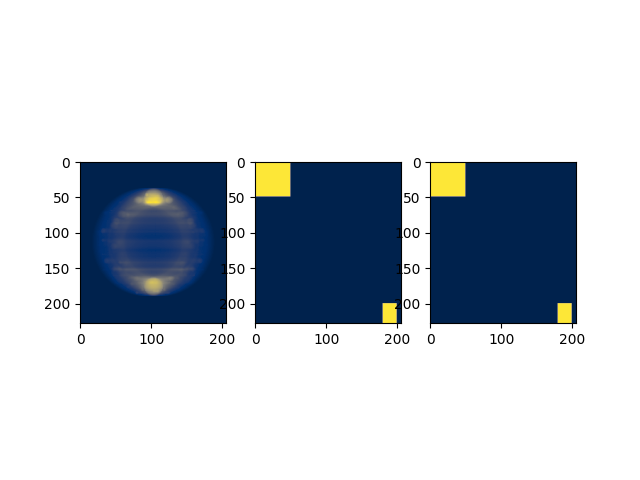

In [22]:
projection = np.abs(unwrapped_sinogram.sum(0))
mask = np.zeros_like(projection)


mask[0:50,0:50] = 1
mask[200:250,180:200] = 1

fig, ax = plt.subplots(1,3)
ax[0].imshow(projection)
ax[1].imshow(mask)
ax[2].imshow(mask*projection)

In [39]:
equalized_sinogram = sscCdi.equalize_scipy_optimization_parallel(unwrapped_sinogram,mask,initial_guess=(0,0,0),method='Nelder-Mead',max_iter = 1,processes=32)

Equalizing frames: 100%|██████████| 361/361 [00:33<00:00, 10.69it/s]
Populating result matrix: 361it [00:00, 7230.97it/s]


## Alignment (wiggle) 

In [ ]:
dic["step_percentage"] = 5 # need to project irregular angle steps to a regular grid?
dic["project_angles_to_regular_grid"] = True 
dic["bad_frames_before_wiggle"] = [] 
dic["wiggle_reference_frame"] = 100

In [ ]:
sscCdi.processing.preview_angle_projection(dic,equalized_sinogram,sorted_angles)

In [ ]:
dic, aligned_sinogram, _ = sscCdi.processing.wiggle_sinogram_alignment(dic,equalized_sinogram, sorted_angles,save=True) # returns: updated dic, aligned_sinogram, wiggle_center_of_mass

In [ ]:
sscCdi.deploy_visualizer(aligned_sinogram[0:10],title="Aligned sinogram",cmap='gray',axis=0)

## Tomography: select dictionary according to tomographic method
- for details on the tomography algorithm inputs, see documentation at https://gcc.lnls.br/wiki/docs/ssc-raft/reconstructions/

In [ ]:
dic['using_wiggle'] = True

dic['automatic_regularization'] = 0 # skip if 0; regularization between 0 and 1 to enhance borders prior to recon (https://www.sciencedirect.com/science/article/pii/S2590037419300883?via%3Dihub)

# dic["algorithm_dic"] = { # if FBP: filtered back-projection
#     'algorithm': "FBP",
#     'gpu': [0,1],
#     'filter': 'lorentz', # 'gaussian','lorentz','cosine','rectangle'
#     'paganin regularization': 0.1, # 0 <= regularization <= 1; use for smoothening
# }

dic["algorithm_dic"] = { # if eEM: emission expectation maximization
    'algorithm': "EM",
    'gpu': [0],
    'regularization': 0.0001,
    'method': 'eEM', 
    'niterations': [20,0,0,0], # [global iterations, iterations EMTV, iterations2 EMTV, Cone-beam integration points]
    'epsilon': 1e-15, #for EMTV only
    'blocksize': 20, # blocks for parallelization
}

## Alignment (Iterative Reprojection) 

In [ ]:
aligned_tomo, sinogram, cumulative_shifts = sscRaft.iterative_reprojection(equalized_sinogram,dic, max_iterations=10, downsampling=2,plot=True,find_shift_method='correlation_parallel',apply_shift_method='scipy',tomo_method='raft',radon_method='raft',n_cpus=32)

In [ ]:
recon3D = sscCdi.processing.tomo_processing.tomography(dic,equalized_sinogram,save=True)

fig, ax = plt.subplots(1,3)
ax[0].imshow(recon3D.sum(0))
ax[1].imshow(recon3D.sum(1))
ax[2].imshow(recon3D.sum(2))

In [ ]:
sscCdi.deploy_visualizer(recon3D,title="Recon",cmap='gray',axis=0)#,limits=(-1,1))

## 3D Equalization

In [ ]:
dic["tomo_remove_outliers"] = 3
dic["tomo_threshold"] = 20.0
dic["tomo_local_offset"] = [] # [top,bottom,left,right, axis]
dic["tomo_mask"] = []

In [ ]:
equalized_tomogram = sscCdi.processing.tomo_equalize3D(dic,recon3D,save=True)

In [ ]:
sscCdi.deploy_visualizer(equalized_tomogram,title="Equalized Recon",cmap='gray',axis=0)

In [ ]:
sscCdi.plot_histograms(recon3D, equalized_tomogram,bins=300)